### Import modules

In [1]:
import h5py
import numpy as np
import gvar as gv
import matplotlib.pyplot as plt
import tqdm

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 'large'

import corr_lib as corr

### Set fit parameters

In [2]:
# modify these
fit_dict = {
    'particle' : 'pion',   # omega (baryon) or pion (meson)
    
    't_start' : 14, 
    't_end' : None,   # if None, set t_end = t_period - t_start (ie, fit symetrically); useful for mesons
    'n_states' : 1   # max choice for n_states is determined by prior
    
}

### Get data from h5 file

In [3]:
# read-in data (from ensemble a15m310)
fh5 = h5py.File('./../data/corr_data.h5', 'r')

# read-in correlators
if fit_dict['particle'] in ['omega', 'pion']:
    raw_correlator_data = {}
    raw_correlator_data['ss'] = np.array(fh5['a15m310/'+fit_dict['particle']])[:,:,0,0]
    raw_correlator_data['ps'] = np.array(fh5['a15m310/'+fit_dict['particle']])[:,:,1,0]
    
    # The following line converts the (raw) correlator data into a gvar variable 
    # with length equal to the number of time slices (the temporal extent of the lattice)
    # and entries equal to the mean(std) of the correlator at each time
    #
    # Note that to determine the uncertainty at each time,
    # it would not be sufficient to simply take the std across each configuration --
    # a correlator only becomes a correlator after averaging!
    # You could find these uncertainties by, eg, bootstrapping,
    # but gvar offers a way to determine these uncertainties without any extra effort on our behalf,
    # so we use that function here
    correlators = gv.dataset.avg_data(raw_correlator_data)
else:
    print("Particle not in h5 file")

# determine whether the particle is mesonic or baryonic
if fit_dict['particle'] in ['omega']:
    particle_statistics = 'fermi-dirac'
elif fit_dict['particle'] in ['pion']:
    particle_statistics = 'bose-einstein'

### Set prior and make fit

In [5]:
# Prior requires keys: wf_ps, wf_ss, E;
# this prior is much wider than the expected fit parameters;
# ideally, you would use the effective mass to get the ground state energy,
# physics (quantum numbers) to get the excited states, and
# the effective wf to get the wf overlap
prior = {}
prior['wf_ps'] = gv.gvar(np.repeat('0.0(1.0)e-04', 6))
prior['wf_ss'] = gv.gvar(np.repeat('0.0(1.0)e-04', 6))
prior['E'] = gv.gvar(np.arange(6)+1, np.repeat(1, 6))

# make fit
my_fitter = corr.Fitter(n_states=fit_dict['n_states'], prior=prior, 
                    t_start=fit_dict['t_start'], t_end=fit_dict['t_end'], 
                    particle_statistics=particle_statistics,
                    correlators=correlators)
my_fit = my_fitter.get_fit()

# print results
print(my_fit)

Least Square Fit:
  chi2/dof [dof] = 0.75 [40]    Q = 0.87    logGBF = 590.99

Parameters:
        wf_ps 0   0.00013106 (56)       [ 0.00000 (10) ]  *
        wf_ss 0   0.00003733 (16)       [ 0.00000 (10) ]  
        log(E0)      -1.4429 (12)       [    0.0 (1.0) ]  *
--------------------------------------------------------
             E0      0.23624 (28)       [    1.0 (1.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 33/0.0)



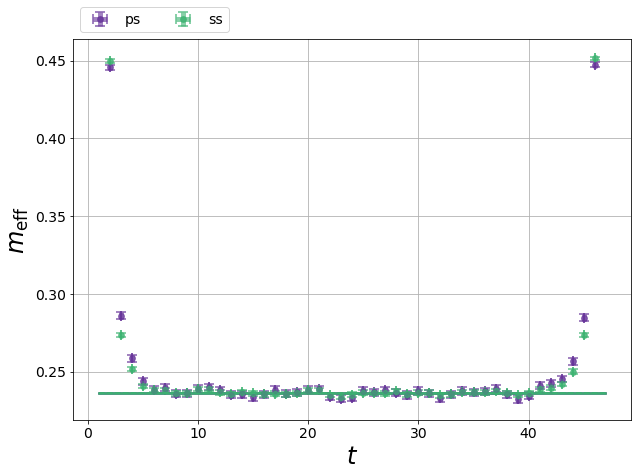

In [6]:
# Plot the effective mass & show fit
# Try fiddling with arguments
my_fitter.plot_effective_mass(tmin=None, tmax=None, ylim=None, show_fit=True)

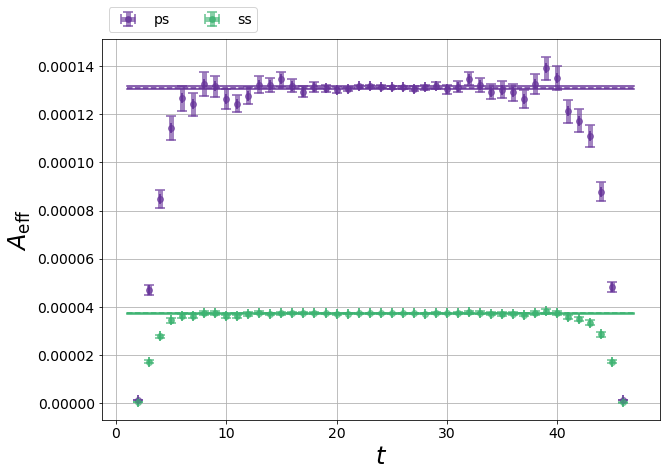

In [7]:
# Plot the effective wf overlaps & show fit
my_fitter.plot_effective_wf(tmin=None, tmax=None, ylim=None, show_fit=True)

### Generate list of indices for bootstrapping

In [8]:
# Generally, you will already have a bootstrap list, or 
# you will generate a single list to use across all particles/fits in a given ensemble;
# for didactic purposes, we generate one here
#
# Essentially, we resample the original data (correlator_data) bs_N times
# to create bs_N bootstrap resamples of the correlator_data (bs_correlator_data);
# if the correlator_data has shape (n_cfgs, n_time_slices),
# generate bs_M = n_cfgs integers between 0 and n_cfgs;
# this list of numbers tells us which configurations when we resample the original data;
# we repeat this process bs_N times to generate bs_N resamples

bs_M = raw_correlator_data['ss'].shape[0] # bs_M would be the same if you used 'ps' instead
bs_N = 50 # In real-world cases, this would probably be much larger
bs_list = np.random.randint(low=0, high=bs_M, size=(bs_N, bs_M))

### Make bootstrap resamples of original data

In [10]:
def resample_correlator(bs_list, n):
    resampled_raw_corr_data = ({key : raw_correlator_data[key][bs_list[n, :], :]
                           for key in raw_correlator_data.keys()})

    resampled_corr_gv = gv.dataset.avg_data(resampled_raw_corr_data)
    return resampled_corr_gv


fit_parameters_keys = sorted(my_fit.p.keys()) # eg, 'wf_ps', 'E0', ..
output = {key : [] for key in fit_parameters_keys}

# Make bs_N fits, one for each of the resampled correlators
for j in tqdm.tqdm(range(bs_N), desc='bootstrap'):

    # Discard gvars created between gv.switch_gvar() 
    # and gv.restore_gvar(). All gvars used in this block 
    # must be created in this block and cannot be accessed
    # outside it (attempting otherwise will lead to a 
    # segmentation fault). Using gv.switch_gvar() / 
    # gv.restore_gvar() will significantly improve performance,
    # especially if bs_N >> 100
    gv.switch_gvar() 

    prior = {}
    prior['wf_ps'] = gv.gvar(np.repeat('0.0(1.0)e-04', 6))
    prior['wf_ss'] = gv.gvar(np.repeat('0.0(1.0)e-04', 6))
    prior['E'] = gv.gvar(np.arange(6)+1, np.repeat(1, 6))
    
    temp_correlators = resample_correlator(bs_list, j)

    # make fit with resampled correlators
    temp_fitter = corr.Fitter(n_states=fit_dict['n_states'], prior=prior, 
                        t_start=fit_dict['t_start'], t_end=fit_dict['t_end'], 
                        particle_statistics=particle_statistics,
                        correlators=temp_correlators)
    temp_fit = temp_fitter.get_fit()

    for key in fit_parameters_keys:
        # Save the best estimate for the central value 
        # of each parameter of each fit

        p = temp_fit.pmean[key]
        output[key].append(p)

    gv.restore_gvar()

# print results -- should be similar to previous results
table = gv.dataset.avg_data(output, bstrap=True)
print('\n\n', gv.tabulate(table))

bootstrap: 100%|██████████| 50/50 [00:00<00:00, 66.43it/s]



   key/index              value
------------------------------
    log(E0)      -1.44299 (96)
    wf_ps 0    0.00013104 (62)
    wf_ss 0    0.00003733 (20)
